In [1]:
#| default_exp energyflux
%reload_ext autoreload
from nbdev.showdoc import show_doc
from utilities.ipynb_docgen import *
!date

Mon Feb  6 14:12:24 PST 2023


Energy and event type information are available in the data, but not used by the current wtlike light curve analysis.


For a single cell the likelihood, derived by Kerr, is,

$$ \displaystyle\log\mathcal{L}(\alpha,\beta\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w + \beta\ (1-w) \big) - (\alpha\ S + \beta\ B) \tag{1}$$


where $w$ represents the set of all weights in the cell, and  $S$ is an estimate for  $\sum w$ using the cell's exposure relative to the full dataset.

We extend this with three modifications. Denoting the energy subset, or band, with an index $k$ we:
- Replace $\alpha$ with a value for each energy band, $\alpha_k$; 
- Break the set $w$ into sets with specific $k$, $w_k$; 
- Replace $S$ with its equivalent for each energy band, $S_k$, the estimate for the value of $\sum w_k$.

In the following we specialize to the usual case $\beta=0$. The likelihood, now a function of the _set_ $\alpha_k$, is a sum over $k$:

$$ \log\mathcal{L}(\alpha_0,\alpha_1,\dots,| w)\ =  \sum_k \big[ \sum_{w_k}  \log ( 1 + \alpha_k\ w_k ) - \alpha_k\ S_k \big],\tag{2} $$

## Calculation of $S_k$

Since the effective area also depends on event type, this is a sum of two terms. Let the function $\mathcal{E}_{kj}(I)$ represent the exposure, in $\mathrm{cm^2\ s}$, for 
energy band $k$ and event type $j$, for the time interval $I \equiv (t_a,t_b)$. Also, let $W_{kj}$ be the sums of $w_k$ for the subsets with
$j$  = Front or Back.

The spacecraft pointing data relevant for a given source is a list of 30-s time intervals, each with a livetime $\tau$ and a value of $z\equiv \cos\theta$. 
Then for an interval $I$, either the full dataset or just a cell, we form an array of the sum of the livetime values binned in $z$. 
The final step to calculate $\mathcal{E}_{kj}$ involves the effective area $A$. This is determined from the $Fermi$ "IRF" tables, defining a function of energy $E$, $z$ and event type, returning values in $\mathrm{cm^2}$. Since we bin in $z$, it is represented by a $16\times 2 \times 12$ matrix for the 16 energy bins, 12 angular bins, and Front/Back. Symbolically, we have $\mathcal{E}(I)$ = $A_{eff} \cdot L(I)$ with $L$ the $12\times 2$ livetime matrix for interval $I$, resulting in the $16\times 2$ exposure matrix.

Thus we have 
$$ S_k =\sum_{j=F,B} \frac{\mathcal{E}_{kj}(I_{cell})}{\mathcal{E}_{kj}(I_{full})} W_{kj} \tag{3}$$

A question is how to prepare the SC data to facilitate this. Here is a snapshot of  $\cos\theta$ for a fraction of a day:

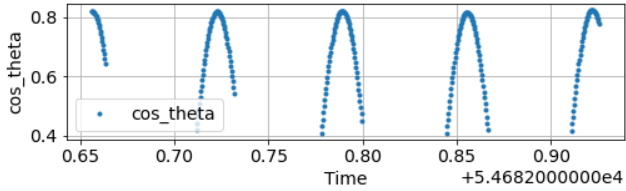

The points are 30s apart, and the source is in the FOV on alternate orbits. Since an orbit is the minimum time interval for a cell, which is only appropriate for extremently bright flares, I propose to make an orbit the basic time unit to save for rebinning. For each orbit, I'll collect the 8x12 matrix $L(I_{orbit})$. 
For each orbit then, I make a sum of livetimes for bins in $z$, keeping the $z$ information.


I can save either the livetime binned in $z$ or, after applying the effective area, the exposure per energy band/event type.
The former has (now) 12 bins, while the latter up to 32 with Front/Back and 16 energy bins. However, this is effectively 14 below 10 GeV, and I could make larger bins above 10 GeV.

### Kerr evaluation of S:

This is an energy independent approach, used by Kerr, which ignores the energies and event types of the photons.
In this case, the
sum of all the weights, $\sum w \equiv W_{total}$ is used, with a relative exposure factor, to estimate the sum of the weights for a cell. The energy dependence of the effective area is averaged over with 
a weighting function $g$ representing the source spectrum.  

So $\mathcal{E}(I) = A \cdot L(I)$ becomes $\bar{\mathcal{E}} = \bar{A} \cdot L(I) $, where
$\bar{A}(z) =  \sum_j \int g(E) A_{j}(E,z)\ dE$, is the energy-weighted effective area, now 
a function only of $z$. In the current approach it is evaluated only for the 12 binned values of $z$, 
instead of for each 30-s exposure interval. Finally,

$$ \bar{S}_{cell} = \frac{ \bar{\mathcal{E}}(I_{cell}) }{ \bar{\mathcal{E}}(I_{total}) } W_{total} \tag{4}$$

---
## Making light curves
The objective is to look for changes over time. We consider two modes:

### Normalization
The basic assumption is that the spectral shape is fixed.
In Eq. (2), set all $\alpha$'s to a single value which makes it identical to Eq. (1)
with the identification 
$$S = \sum_k S_k \tag{5}.$$ 
Compare this with the Kerr approach:
$$ S = \frac{f(I_{cell})}{f(I_{total})} \sum w,$$
where $f(I)$ is an effective exposure weighted by an energy spectrum for the interval. He used a weighting
function $E^{-2.1}$.
The actual source spectrum should be an better alternative.
 
### Spectral shape
As the count mode detects changes in the level of flux, assumimg a constant spectrum, we will try
to charactrize a <i>change</i> corresponding to a difference corresponding to multiplication
by a power law. The nominal logarithmic energy spectrum, $E\ \frac{dN}{dE}$, is proportional to the $S_k$'s.


Since energies are digitized to 4 bins per decade from 100 MeV to 1 TeV, with the logarithmic bin center
value representing the bin's energy, we have $E_k = 10^{(k+1/2)/4} \times 100 \mathrm{MeV}$ with $k=0,\ldots, 15$. (But only the first eight play a role in this analysis.)

So we want a likelihood expression, like Equation (2), with a parameter that characterizes a
power law spectral factor. We use $f(E,\gamma) = \big( \frac{E}{E_c} \big)^{-\gamma}$ where $E_c=1\ \mathrm{GeV}$. 
The nominal value for $\gamma$ is zero.

Then $$ \frac{df(E_k,\gamma)}{d\gamma} = (3.5-k)\ \frac{\log(10)}{4} $$

In [2]:
#| export
import sys, os
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from wtlike.source_data import SourceData
from wtlike.config import *
from wtlike.loglike import LogLike
from wtlike.poisson import Poisson
from wtlike.effective_area import EffectiveArea
from wtlike.lightcurve import flux_plot
plt.rc('font', size=12)

In [3]:
#| include: false
# Ec =1000
# f = lambda E,g : (E/Ec)**-g
# Ebin = 10**np.arange(2.125, 4, 0.25); Ebin
# delta=1e-6
# q=(f(Ebin, delta) -f(Ebin, -delta))/(2*delta)

# r = (3.5-np.arange(8))* np.log(10)/4
# q/r

Consider a single energy term in Eq. (2). Factor possible changes in the flux into an overall normalization change represented by $\alpha$, so we have an actual factor of $(1+\alpha)$ and that from $f(E_k,\gamma)$. Expand the latter to first order since we expect $|\gamma|<<1$, and keeping only
first-order terms to obtain
$$ \log\mathcal{L}_k(\alpha, \gamma)\ =  \sum_{w\in W_k} \log\big(1+(\alpha+c_k\gamma)w\big) - (\alpha+c_k\gamma)\ S_k, $$
where $c_k = \log(E_k/E_c)=\frac{\log(10)}{4}(3.5-k)$.

#### Implementation note
The code, see the class `Poisson`, uses a Poisson-like representation of $\log\mathcal{L}_k(\alpha)$ for each cell.

That can be reinterpreted as a function of $\alpha + c_k\gamma$. 

For $s>0$, 
$$\log \mathcal{L}(s | s_p,e,b) = e\ \big[\  (s_p+b) \ \log( s+b ) - s\ \big] + \mathrm{const},$$
where the const is conventionally defined such that the log likelihood is zero at the peak.

For $s_p >> b$ or $e>>1$, the distribution approaches the normal distribution, and can be represented as, 

$$ s = s_p \pm \sqrt{\frac{s_p+b}{e}}.$$

Here $s$ is the flux, $1+\alpha$. 

These functions representing each subcell are created from the data. For a given cell, the likelihood for the flux for a cell is the the sum shown in Eq. (2). The modification for each of 
the subcell likelihood functions involves dividing the $e$ paramater for each function by $c_k$.

In [4]:
#| exporti
def contiguous_idx(exposure, min_gap=20, min_duration=600):

    """ return a start/stop interleaved array for contiguous intervals

    """

    stop = exposure.stop.values
    start = exposure.start.values

    # interleave  the starts and stops
    ssint = np.empty(2*len(start))
    ssint[0::2] = start
    ssint[1::2] = stop

    # Tag the (stpp,start) pairs < 10 sec as  not adjacent
    not_adjacent = np.diff(ssint)[1::2] > min_gap/(24*3600) ;
    #print(f'{sum(not_adjacent)} (start,stop) pairs are not closer than {min_gap} s')

    # make a mask, keep ends
    mask = np.empty(2*len(start), bool)
    mask[0] = mask[-1] = True
    #

    # insert into mask -- keep only the (stop,start) pairs  which are not adjacent
    mask[1:-2:2] = not_adjacent
    mask[2:-1:2] = not_adjacent

    # apply mask, split into start and stop
    # keep = ssint[mask]
    r = (np.arange(len(mask))//2)[mask]
    
    # reshape as (start,stop) pairs X entries in exposure
    return r.reshape(len(r)//2,2)

In [5]:
#| export
def pull_plot(pulls, ax=None, nbins=25, **kwargs):
    """ Histogram of a set of "pulls", presumed to be normal (0,1) distributed, 
    the function for which is overplotted.
    """
    from scipy import stats
    x = pulls[~np.isnan(pulls)]
    
    fig, ax = plt.subplots(1,1, figsize=(5,3)) if ax is None else (ax.figure, ax)
    if len(x)<2:
        ax.text(0.5, 0.5, '(no data)', color='red',
                transform=ax.transAxes, ha='center', va='center', )
        ax.set(xticks=[], yticks=[])
        return fig
    
    kw = dict(ylim=(0.,0.45))
    kw.update(kwargs)
    ax.set(**kwargs)
    ax.hist(pulls, np.linspace(-5,5,nbins+1), histtype='step', lw=2, density=True, )
    dom = np.linspace(-5,5,101)
    ax.plot(dom, stats.norm.pdf(dom), '--', lw=2,)# label='Normal(0,1)')
    ax.grid(alpha=0.5)
    
    ax.text(0.95, 0.97,f'{len(x)}\n{np.nanmean(x):.3f}\n'+r'$\pm$'+f'{np.nanstd(x):.3f}',
            transform=ax.transAxes, ha='right', va='top',  
            fontdict=dict(family='monospace'), fontsize=8 )
    return fig

In [6]:
#| exporti
class LivetimeHistory:
    """
    Manage the livetime history
    The spacecraft history is a sequence of 30-s intervals each with a livetime<30s and a value for z=$\cos\\theta$.
    
    This class makes a table for each contiguous interval, usually an orbit of the summed livetime for bins in z.
    
    It creates a table of 
    """
    ctbins=np.linspace(0.4,1.0,13)

    def __init__(self, wtl ):
        """
        - wtl : a WtLike object with SC history,
              the exposure DataFrame has columns start, stop, livetime, cos_theta
        """
        self.source_name = wtl.source_name
        edf = wtl.exposure
        def lt_table(edf, istart, iend):
            df = edf.iloc[istart:iend+1,]
            h,_ = np.histogram(df.cos_theta, bins=self.ctbins, weights=df.livetime)
            return  h.astype(np.float32)
        
        # makes  a table of the start/stop indices for contiguous chunks
        idx = contiguous_idx(edf)
        
        self.start = edf.start.values[idx[:,0]]
        self.stop  = edf.stop.values[idx[:,1]]
        lt    = np.array([lt_table(edf, a,b) for (a,b) in idx], np.float32 )
        self.cum_lt  = np.insert(np.cumsum(lt, axis=0), 0, np.zeros(12), axis=0);
        
    def __repr__(self):
        
        return f'Spacecraft history for source {self.source_name}: a table of {self.cum_lt.shape} entries'
        
    def __call__(self, index_range=None):
        """Return the live time array for the range of orbit indices

        """    
        if index_range is None:
            return self.cum_lt[-1]

        return self.cum_lt[index_range[1]] - self.cum_lt[index_range[0]]
    
    #---------------------------------------------------
    #        plot routines
    #--------------------------------------------------
 
    def lt_vs_ct(self, ax=None):
        """ Plot of livetime vs $\cos\\theta$.
        """

        fig, ax = plt.subplots(figsize=(5,3)) if ax is None else (ax.figure, ax)
        cumx  = self.cum_lt[-1] 
        ax.stairs(100* cumx/sum(cumx), self.ctbins, lw=2)
        ax.set(xlim=(0.4,1.0), xlabel=r'$\cos\theta$', ylabel='Fraction (%)')
        ax.grid(alpha=0.5)
        
    def lt_vs_time(self, ax=None, tbinsize=120):
        """ Plot of livetime fraction vs time.
        """

        # sum over cos theta to get cumulative total livetime 
        cuml = np.sum(self.cum_lt,axis=1)

        # the time interval array of bin edges
        tbins = np.arange(self.start[0], self.stop[-1], tbinsize)
        # index of the time dimension 
        cum_idx  = np.searchsorted(self.start, tbins)

        fig, ax = plt.subplots(figsize=(12,2)) if ax is None else (ax.figure, ax)
        ax.stairs(np.diff(cuml[cum_idx])/(tbinsize*24*3600), tbins, lw=2);
        ax.set(xlabel='Time (MJD)', ylabel='Livetime fraction');
        ax.grid(alpha=0.5);

In [7]:
#| export
class EnergyCells(object):
    r"""
    Create a set of cells using energy-dependent livetime
    
    Input is an instance of the `SourceData` class for a given source, containing photon and spacecraft info 
    
    Processing creates:
     
    * Orbit-based exposure vs $\cos\theta$, implemented by `LivetimeHistory` and using the effective area
            
    * The basic time-defined cells, implemented by `FermiInterval`
    
    Each cell has 8 sub-cells for the 4/decade energies from 100 MeV to 10 GeV. Then the likelihood function
    for each sub-cell is determined using the tools `LogLike` and `Poisson`.  
    
    """    
        
    def __init__(self, wtl:'SourceData object', interval,
                adjust_slope=-0.55):
  
        if not isinstance(wtl, SourceData):
            raise TypeError(f'Expect {wtl} to be an instance of SourceData')
            
        self.interval = interval 
        lth = LivetimeHistory(wtl)
        self.config = wtl.config
        self.photons = wtl.photons
        self.Aeff =  EffectiveArea(file_path=self.config.datapath/'aeff_files').tabulate()
        self.adjust_slope = adjust_slope
        # orbit info from the LivetimeHistory object
        self.source = wtl.source
        self.source_name = wtl.source_name
        self.lth = lth
        self.orbit_times = 0.5*(lth.start+lth.stop)
        
        # setup all the cells/subcells with front/back mask
        self.cells = self.make_cells()
        # self.ss, self.bb = self._get_S_and_B()
        self.ftable = {}


    def make_cells(self):
        """
        create a cell DF corresponding to the interval
        """
        # get interval info
        self.fi = fi =  FermiInterval(self.interval)
        self.ncells = len(fi)
        cell_edges = fi.mm
        # get the orbit indeces for each cell 
        ci = cell_indices = np.append(np.searchsorted(cell_edges, self.orbit_times), 99999)

        # differences show transition (with guard at end)
        cidiff = np.append(np.insert(np.diff(ci),0,0),99);
        # array of where changes are
        cichange = (cidiff>0)[:-1]

        # then the corresponding starting orbit indices and cell numbers
        t = np.arange(len(ci))[cichange]

        # orbit indices for start and stop in the cell
        # effective times from those
        oi_start = np.arange(len(ci))[t[:-1]]
        oi_stop  = np.arange(len(ci))[t[1:]]
        tstart   = self.lth.start[oi_start]
        tstop    = self.lth.stop[oi_stop-1]
        # dt       = tstop-tstart

        # reconstruct cell numbers, allowing for missing ones in cell_indices array
        cell_number = np.cumsum(cidiff[:-1][cichange])-1 
        xdf = pd.DataFrame.from_dict(dict(
                    orbit_index_range = [(a,b) for a,b in zip(oi_start, oi_stop)],
  
                             )
                        )
        xdf.index=cell_number[:-1]
        xdf.loc[:,'time'] = cell_edges[xdf.index] + self.interval/2
        
        event_times = self.photons.time.values
        # 

        # make an interleaved (start,stop) array of the actual cell edges
        cell_edges = np.empty(2*len(xdf))
        cell_edges[::2] = tstart
        cell_edges[1::2] = tstop

        # get ranges of eventindices per cell
        event_cell_indices = np.searchsorted(event_times, cell_edges ).reshape(len(xdf),2)

        xdf.loc[:,'event_index_range'] = [tuple(t) for t in event_cell_indices]
        return xdf['time orbit_index_range event_index_range'.split()]

    def _get_Fbar(self):
        """Return the normalized cell exposure matrices as a (Ncells x 16 x 2) numpy array 
        """
        L = np.array([ cell['livetime'] for cell in self]).T
        F_cells = np.dot(self.Aeff, L)
        F_full = F_cells.sum(axis=2).T
        F_bar = F_cells.T / F_full

        return F_bar #.shape, F_bar[0]

    # def _get_wsum(self):
    #     """Return the summed weights as a ( 16 x 2) numpy array
    #     """ 
    #     Wsum = np.zeros(32)
    #     for k, v in  self.photons.groupby('band'):
    #         Wsum[k] = v.weight.sum()
    #     return Wsum.reshape((16,2) )

    def _get_S_and_B(self, fbmask=3):
        """Return the expected sum(w) and sum(1-w) as (Ncell X 16) arrays
        
        - fbmask-- 1,2,3 for F, B, F+B
        """ 

        vmask = [[0,0], [1,0], [0,1], [1,1]][fbmask]
        
        # sum the weights according to energy/event type index
        W = np.zeros(32)
        N = np.zeros(32)
        for k, v in  self.photons.groupby('band'):
            W[k] = v.weight.sum()
            N[k] = len(v.weight)
        # reshape to enable explicit F,B index
        W = W.reshape((16,2))
        N = N.reshape((16,2))

        # now use the normalized exposure matrix, then sum over front, back
        F_bar = self._get_Fbar() 
        # S = (F_bar * W).sum(axis=2)
        # B = (F_bar * (N-W)).sum(axis=2) 
        Sk = np.dot( F_bar * W, vmask) 
        Bk = np.dot( F_bar * (N-W), vmask) 
        
        # ad-hoc adjustment per cell depending on energy distribution

        a = self.energy_adjustment()
        return Sk * a, Bk * a

    def energy_adjustment(self):
        # either 1 or a column vector of factor for each cell
        # preferred? -0.55
        slope = getattr(self, 'adjust_slope', None)
        if slope is None: return 1
    
        ew = self.energy_moment()
        return (1 + slope*ew)[:,None]
        

    def __getitem__(self, k):
        """ #### Index: return a dict for cell # k
        It is compatible with the LogLike class
        
        * time: central time (MJD)
        * livetime array 
        
        For the events in the cell, arrays of:
        * bands: 'bands'
        * weights: 'w' 
        """
        t = dict( self.cells.iloc[k,:])
        r = dict(time=t['time'])
        oir = t['orbit_index_range']
        eir = t['event_index_range']
        r['livetime'] = self.lth(oir)
        r['bands'] = self.photons.band.values[slice(*eir)]
        r['w'] = w = self.photons.weight.values[slice(*eir)].astype(np.float32)
        r['n'] = len(w)
        if hasattr(self, 'ss'):
            # after setup, need these
            r['Sk'] = self.ss[k].astype(np.float32)
            r['Bk'] = self.bb[k].astype(np.float32)
            # sums for normalization flux
            r['S'] = np.sum(r['Sk'])
            r['B'] = np.sum(r['Bk'])
        return r

    def __len__(self):
        return self.ncells
    
    def __repr__(self):
        return f'EnergyCells: manage energy-dependent cells for source {self.source_name} with {self.ncells} {self.interval}-day cells'
    
   
    def flux_table(self, fbmask=3,  monitor=False):
        """Return a Ncells x 8 DataFrame of Poisson objects
        index is time, column name is energy index
        
        """
        ft = self.ftable.get(fbmask, None)
        if ft is not None:
            return ft
            
        def cell_w(cell, fbmask=3, nbands=8):
            """
            For a given cell, return a dict of weights for nbands, with Front/Back selection
            """
            photons = pd.DataFrame.from_dict(
                dict( eband=cell['bands']//2, 
                     evtbit=cell['bands']%2+1, 
                     weight=cell['w'])
                )
            if fbmask<3: #possible values: 1 (Front), 2(back), or 3(both)
                photons = photons[np.bitwise_and(photons.evtbit, fbmask)>0]

            ecells = {}
            for k, v in photons.groupby('eband'):    
                ecells[k] = v.weight.values
            return ecells

        def subcell_poisson(cell, Sk,Bk, fbmask=3, nbands=8):

            cw = cell_w(cell, fbmask, nbands)

            pr = [] 
            for k in range(nbands):
                w = cw.get(k,[])
                if len(w)<2:
                    # non-valid for little of no info
                    p = Poisson((0,np.nan,0))
                else:
                    subcell = dict( w=w, n=len(w), S=Sk[k], B=Bk[k],)
                    p = Poisson.from_function(LogLike(subcell)) 
                pr.append(p)
            return pr

        subs = {}
        S, B = self._get_S_and_B(fbmask)

        for i, cell in enumerate(self):
            if monitor: print(f'\rCell index: {i:4d} /{n-1:4d} ', end='')
            Sk,Bk = S[i], B[i]
            subs[cell['time']] = subcell_poisson(cell, Sk,Bk, fbmask)
        ft =  pd.DataFrame.from_dict(subs, orient='index')
        self.ftable[fbmask]=ft
        return ft
    
    
    
    def count_flux(self, fbmask=None):
        """Return a frame with the relative count flux Poisson-like log-likelihoods,  combining the energy-dependent
        likelihoods.
        """
        
        
        if fbmask is None:
            # add all Sk
            Sk,Bk, = self._get_S_and_B()
            fits = []
            for cell, S,B in zip(self, Sk, Bk):
                cell['S'] = S.sum()
                cell['B'] = B.sum()
                fits.append( Poisson.from_function(LogLike(cell) ))
            t=np.array([cell['time'] for cell in self]); width = np.diff(t)[0]; 
            
        else:
            # fbmask specified: make table add log-likelihoods 
            ft = self.flux_table(fbmask)
            valid = lambda poiss: poiss.p[1]>1
            fits = []

            for i, plist in ft.T.iteritems(): 
                filtered = list(filter(valid,plist))
                if len(filtered)==0: # completely empty
                    t = plist[0]
                elif len(filtered)==1: # only one
                    t = filtered[0]
                else:
                    t = Poisson.from_list(filtered) 
                fits.append(t) 
            t=np.array(ft.index); width = np.diff(t)[0]; 
        
        df = pd.DataFrame(dict(t=t, 
                               tw=np.full(len(t),width), 
                                fit=fits)
                         )
        return df
    
    def energy_moment(self):
        """ Return a measure of the exposure energy distribution.  
        """
        F = self._get_Fbar()[:,:8].sum(axis=2)    
        return (np.arange(8) * F).sum(axis=1) / F.sum(axis=1) - 3.5
    


    def spectral_index(self, fbmask=3, tol=0.3):
        """
        
        """
        
        def add_loglikes(plist, scale_sigs=None):
            """ 
            - plist -- list of (presumably 8) of Poisson objects to combine
            - scale_sigs -- None | list of factors to scale up sigma 
            """

            isvalid = lambda poiss: poiss.p[1]>1
            adjusted = lambda p, c : Poisson([p[0], p[1]/c**2, p[2]]) 

            if scale_sigs is not None:
                # if rescaling, replace the list 
                plist = [adjusted(poiss.p,c) for poiss,c in zip(plist, scale_sigs)]
            # remove any invalid ones
            filtered = list(filter(isvalid,plist))
            if len(filtered)==0: return plist[0]# completely empty
            if len(filtered)==1: return filtered[0] # only one

            return Poisson.from_list(filtered, tol=tol) 
        
        ft = self.flux_table(fbmask)
        ck = np.log(10)/4 * (3.5-np.arange(8))

        fits = [ add_loglikes(plist, scale_sigs=ck)  for t, plist in ft.iterrows()]
        t=np.array(ft.index)
        return pd.DataFrame(pd.Series(fits, index=t))

    #=========================================================================
    #           plot functions
    #--------------------------------------------------------------------------
    
    def plot_count_flux(self, ax=None, **kwargs):
        """Plot of the relative count flux vs. time. 

        """
        return flux_plot( self.count_flux(),
                         ax=ax, title='Count relative flux using energy', **kwargs);
   
    def plot_fractional_livetime(self, ax=None):
        """Fractional live time per cell
        """

        clt  = self.lth.cum_lt
        cell_live_time = self.cells.orbit_index_range.apply(lambda oir: sum(clt[oir[1]]-clt[oir[0]]))  

        fig, ax = plt.subplots(figsize=(12,3)) if ax is None else (ax.figure, ax)
        ax.plot( self.cells.time.values,  cell_live_time  /(self.interval*24*3600), '+g')
        ax.set(xlabel='MJD', ylabel='Livetime fraction', ylim=(0,None), )
        return fig
    
    def plot_lt_vs_w(self, ax=None, **kwargs):
        """ The total livetime per cell vs the sum of weights
        """
        fig, ax = plt.subplots(figsize=(8,3)) if ax is None else (ax.figure, ax)
        q = np.array([(sum(c['w']), sum(c['livetime'])) for c in self])
        ax.plot(q[:,0], q[:,1]/1e3, '.')
        kw = dict(xlabel='sum of weights', ylabel='live time (ks)')
        kw.update(kwargs); ax.set(**kw)
        ax.grid()
        return fig
   
    def plot_wsum_vs_ssum(self, ax=None, **kwargs):
        """Comparison of the ratio of the sum of weights per cell to the expected value, assuming a constant source.
        """
        wsum = np.array([sum(c['w']) for c in self])
        
        S, B = self._get_S_and_B()
        
        ssum = S.sum(axis=1)
        
        fig, ax = plt.subplots(figsize=(8,3)) if ax is None else (ax.figure, ax)
        ax.plot(ssum, (wsum/ssum).clip(0.8,1.2), '.');
        kw = dict(ylabel=r'\sum w\ /\ S$', xlabel=r'$S$', ylim=(0.8,1.2))
        kw.update(kwargs)
        ax.set(**kw)
        # ax.plot([0,wsum.max()], [0,wsum.max()], ':', color='orange')
        ax.axhline(1, color='grey')
        ax.grid();
        return fig

    def plot_ecell_likelihoods(self, icell, nbands=8, ax=None):
        """ Plots of the likelihoods for energy bands of a given cell
        """
        SS,BB = self._get_S_and_B()
        cell = self[icell]

        # make energy subcells
        ecells = {}
        photons = pd.DataFrame.from_dict(dict(eband=cell['bands']//2, weight=cell['w']))
        for k, v in photons.groupby('eband'):    
            ecells[k] = v.weight.values

        # sums = np.array([sum(w) for w in ecells.values()],)

        ll = [] 
        for ic in range(nbands):
            subcell = dict( w= ecells[ic], n=len(ecells[ic]), S=SS[icell][ic], B=BB[icell][ic])
            ll.append(LogLike(subcell))

        fig, axx = plt.subplots(nrows=2, ncols=4, figsize=(12,4),sharex=True, sharey=True) if ax is None else (ax.figure, ax)
        plt.subplots_adjust(hspace=0, wspace=0)
        fig.suptitle(f'cell #{icell}')
        for ell,ax in zip(ll, axx.flatten()):
            ell.plot(ax=ax, ylabel='')
            ax.axvline(1, color='grey', ls='--')
            
    def plot_livetime_per_band(self, tmax=2e4,   **kwargs):
        """Scatter plot of the livetime, in ks, for each energy band. Plots are capped at {tmax} s. 
        Points with zero are red.
        """
        
        lt = np.array([cell['livetime'] for cell in self])
        df = pd.DataFrame(lt)
        fig, axx = plt.subplots(nrows=8, figsize=(12,8), sharex=True, sharey=True)
        plt.subplots_adjust(top=0.94, hspace=0)
        fig.suptitle(f'Live time per band ({self.interval}-day interval)')
        t = self.cells.time.values
        kw = dict(xlabel='MJD')
        kw.update(kwargs)
        for i, ax in enumerate(axx):
            x = df.iloc[:, i].clip(0, tmax)*1e-3
            ax.set(**kw)
            ax.plot(t, x, '.');
            ax.plot(t[x==0], x[x==0], '.r')
        return fig
            
    def plot_fluxes(self,  **kwargs):
        """Flux light curves for each energy band.
        """
        from wtlike.lightcurve import flux_plot
        flux_table = self.flux_table()

        fig, axx = plt.subplots(nrows =8, figsize=(15,12), sharex=True, sharey=True)
        fig.suptitle(f'Energy-band lightcurves for {self.source_name}')
        plt.subplots_adjust(hspace=0, top=0.95)
        width = np.diff(flux_table.index)[0]
        for iband, ax in enumerate(axx.flatten()):
            lc = pd.DataFrame.from_dict(dict(t=flux_table.index, tw=width, fit=flux_table.iloc[:,iband]))
            ax.axhline(1, color='grey')
            flux_plot(lc, ax=ax, source_name=f'Energy {iband}', axhline=dict(color='grey'), **kwargs)
        return fig
    
    def plot_poisson_parameters(self, **kwargs):
        """Scatter plot of the width and background poisson parameters.
        """

        ft = self.flux_table()
        f1 =  np.vectorize(lambda x: x.p[1])
        f2 =  np.vectorize(lambda x: x.p[2])

        z =   ft.T #to_numpy().T

        fig, ax = plt.subplots(figsize=(10,6))
        kw = dict(xlim=(0,None), xlabel='sqrt(count equivalence)',
               ylim=(-0.1,1.25), ylabel='relative background',
              title='Poisson parameters')
        kw.update(kwargs)
        ax.set(**kw)
        for i, (x,y) in enumerate(zip(f1(z),f2(z))):
            t = np.sqrt(np.where(x>0, x, 0) )
            ax.plot(t, y, '.', label=f'band {i}');
        ax.legend();ax.grid();
        return fig


In [8]:
show_doc(EnergyCells)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/energyflux.py#L159){target="_blank" style="float:right; font-size:smaller"}

### EnergyCells

>      EnergyCells (wtl:SourceDataobject, interval, adjust_slope=-0.55)

Create a set of cells using energy-dependent livetime

Input is an instance of the `SourceData` class for a given source, containing photon and spacecraft info 

Processing creates:

* Orbit-based exposure vs $\cos\theta$, implemented by `LivetimeHistory` and using the effective area

* The basic time-defined cells, implemented by `FermiInterval`

Each cell has 8 sub-cells for the 4/decade energies from 100 MeV to 10 GeV. Then the likelihood function
for each sub-cell is determined using the tools `LogLike` and `Poisson`.

In [9]:
#| code-fold: true

self = None # will be set below
@ipynb_doc
def setup_test(name='Geminga',  interval=7):  ##PSR J1227-4853'
    """ # Study {name} with {interval}-day bins
    
    Create an instance of an `EnergyCells` object to use for the following plots.
    Setting the Front-Back mask to {fbmask}.
    {output}
    """
    global self
    with capture_show('Printout') as output:
        wtl = SourceData(name)
        self =  EnergyCells( wtl, interval)
    return locals()
setup_test()

# Study Geminga with 7-day bins

Create an instance of an `EnergyCells` object to use for the following plots.
Setting the Front-Back mask to {fbmask}.
<details open class="nbdoc-description" >  <summary> Printout </summary>  <div style="margin-left: 25px;"><pre>SourceData:  PSR J0633+1746: Restoring from cache with key "PSR J0633+1746_data"<br>SourceData: Source Geminga with:<br>	 data:     1,222,521 photons from 2008-08-04 to 2022-09-28<br>	 exposure: 3,434,143 intervals,  average effective area 2693 cm^2 for 102.7 Ms<br>	 rates:  source 3.31e-06/s, background 1.11e-06/s, TS 2589330.0<br></pre></div> </details>


In [10]:
#| export
def pull_plot(pulls, ax=None, nbins=25, **kwargs):
    """ Histogram of a set of "pulls", presumed to be normal (0,1) distributed, 
    the function for which is overplotted.
    """
    from scipy import stats
    x = pulls[~np.isnan(pulls)]
    
    fig, ax = plt.subplots(1,1, figsize=(5,3)) if ax is None else (ax.figure, ax)
    if len(x)<2:
        ax.text(0.5, 0.5, '(no data)', color='red',
                transform=ax.transAxes, ha='center', va='center', )
        ax.set(xticks=[], yticks=[])
        return fig
    
    kw = dict(ylim=(0.,0.45))
    kw.update(kwargs)
    ax.set(**kwargs)
    ax.hist(pulls, np.linspace(-5,5,nbins+1), histtype='step', lw=2, density=True, )
    dom = np.linspace(-5,5,101)
    ax.plot(dom, stats.norm.pdf(dom), '--', lw=2,)# label='Normal(0,1)')
    ax.grid(alpha=0.5)
    
    ax.text(0.95, 0.97,f'{len(x)}\n{np.nanmean(x):.3f}\n'+r'$\pm$'+f'{np.nanstd(x):.3f}',
            transform=ax.transAxes, ha='right', va='top',  
            fontdict=dict(family='monospace'), fontsize=8 )
    return fig

class FluxFixer():

    def __init__(self, fluxfits, emom):
        self.fluxfits = fluxfits
        fluxes = fluxfits.apply(lambda x: x.flux)
        x, y = emom, fluxes-1
        self.x=x; self.y = y
        
        class LSQ():
            def __init__(self, x, y):
                self.a, self.b = np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y, rcond=None)[0]
            def __call__(self, x):
                return self.a*x + self.b
            def __repr__(self):
                return rf'$y={self.a:.2f}x + {self.b:.3f}$'
        self.fitfun = LSQ(x,y)
        
    def scatter_plot(self, ax=None, xlim=np.array([-0.12,0.2]), ylim=(-1,1)):
        
        fig, ax = plt.subplots(figsize=(10,3)) if ax is None else (ax.figure, ax)
        
        ax.plot(xlim, self.fitfun(xlim), '--', color='orange', label=f'least-squares fit:\n{self.fitfun}')
        ax.set(ylim=ylim, xlim=xlim);
        ax.grid(alpha=0.5)
        ax.scatter(self.x, self.y, marker='.',); 
        ax.legend(loc='upper right')
        ax.axhline(0, color='grey')
        
    def pull_std(self):
        return self.fluxfits.apply(lambda x: x.sigma_dev(1)).std()
        
    def pull_hist(self, ax=None, fixit=False, **kwargs):
        
        if fixit:
            fits = self.fluxfits.values
            adjust = self.fitfun(self.x)
            pulls = np.array([fit.sigma_dev(yy+1) for fit, yy in zip(fits, adjust)])
        else:
            pulls = self.fluxfits.apply(lambda x: x.sigma_dev(1))
            
        fig, ax = plt.subplots(figsize=(2,1.5)) if ax is None else (ax.figure, ax)
        kw=dict(yticks=[], ylim=(0,0.5))
        kw.update(kwargs)
        pull_plot(pulls, ax=ax, **kw)
        
    def plot_fix(self):

        fig, (ax1,ax2, ax3) = plt.subplots(ncols=3, figsize=(8,1.5), 
                                           gridspec_kw=dict(width_ratios=[3,1,1]))
        plt.subplots_adjust(wspace=0.1)
        self.scatter_plot(ax=ax1)
        self.pull_hist(ax=ax2)
        self.pull_hist(ax=ax3, fixit=True)
 

## Energy Band light curve

Each 7-day cell has 8 sub-cells for the 4/decade energies from 100 MeV to 10 GeV.

Thus we can construct a light curve for each energy band:
<figure style="margin-left: 25px" title="Figure 1">   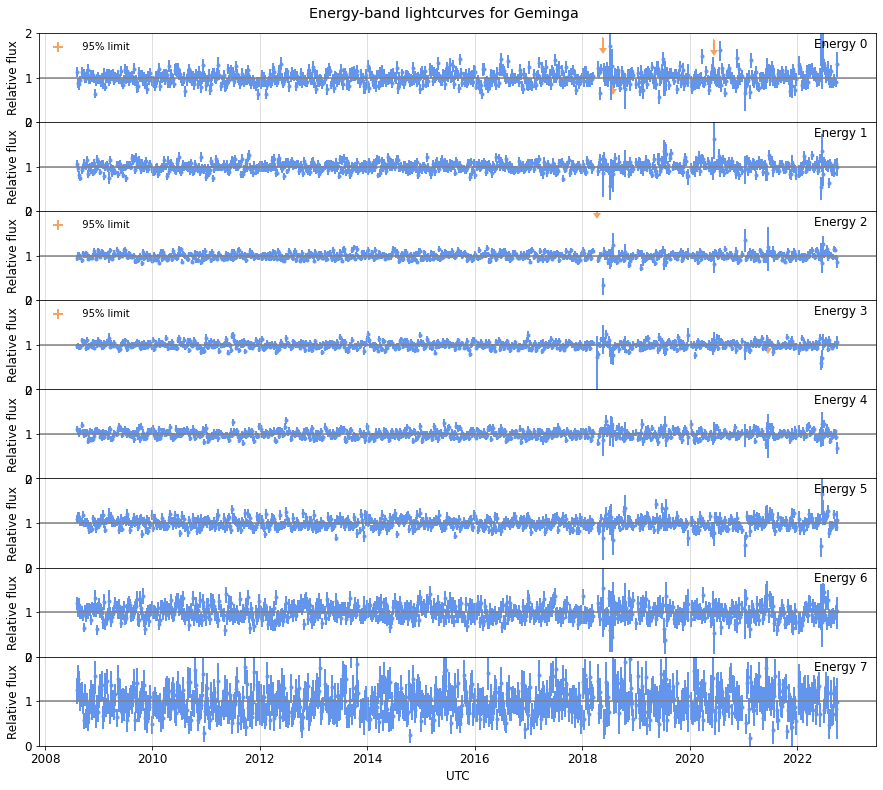  <figcaption><b>Figure 1</b>. Flux light curves for each energy band.
        </figcaption></figure>


In [11]:
#| code-fold: true
@ipynb_doc
def ebands_plot(self, **kwargs):
    """ ## Energy Band light curve
    
    Each {self.interval}-day cell has 8 sub-cells for the 4/decade energies from 100 MeV to 10 GeV.
    
    Thus we can construct a light curve for each energy band:
    {fig}
    """   
    fig = figure(self.plot_fluxes,**kwargs)

    return locals()

ebands_plot(self, ylim=(0,2), UTC=True )

In [12]:
x = self.energy_moment()
i=0
y = self.flux_table(1).iloc[:,i].apply(lambda x: x.flux).values #describe()

sum(np.isnan(y))

0

### Pull plots
The following show the pull histograms for each energy band.

#### Front
<figure style="margin-left: 25px" title="Figure 1">   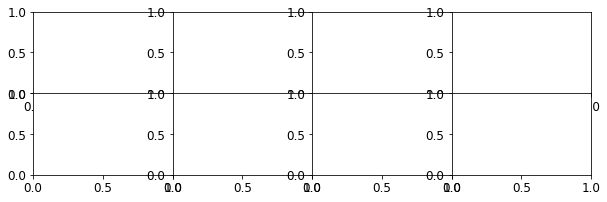 </figure>


#### Back
<figure style="margin-left: 25px" title="Figure 1">   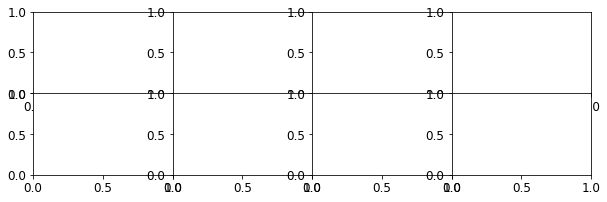 </figure>


In [13]:
#| code-fold: true
@ipynb_doc
def flux_pull_plots(self, fbmask):
    """
    #### {which}
    {fig}
    """
    which = ['','Front','Back', 'Both'][fbmask]
    x = self.energy_moment()
    pff=[]
    for i in range(0):
        print(i)
        try:
            pff.append(FluxFixer( self.flux_table( fbmask).iloc[:,i] , x))
        except Exception as e:
            print(f'Fail for {which[fbmask]} {i}: {e}', file=sys.stderr)
            pff.append(None)
        
    # pff = [FluxFixer( self.flux_table( fbmask).iloc[:,i] , x) for i in range(8)]
    fig,axx = plt.subplots(2,4, figsize=(10,3))
    plt.subplots_adjust(hspace=0, wspace=0)
    for pf, ax in zip(pff, axx.flatten()):
        pf.pull_hist(ax=ax)
    return locals()
display_markdown("""
    ### Pull plots
    The following show the pull histograms for each energy band.
    """)
flux_pull_plots(self,1)
flux_pull_plots(self,2)

In [14]:
#| include: false
def check_fits(self, fixed=None, #lamba x: 0.54*x, quiet=True):
               quiet=True):  
    x = self.energy_moment()
    fit_info = dict()
    for j in range(3):
        if not quiet: print(f'fbmask={j+1}')
        fluxtable = self.flux_table( j+1)

        pff = [FluxFixer( fluxtable.iloc[:,i] , x) for i in range(8)]
        for k in range(8):
            t = pff[k]
            adjust = t.fitfun(t.x) if fixed is None else fixed(x)
            fits = t.fluxfits
            
            flux = fits.apply(lambda x: x.flux)
            if flux.values.mean()==0: continue # no data
            alpha = flux-1
            px = fits.apply(lambda x: x.sigma_dev(1))
            
            
            pxa = np.array([fit.sigma_dev(yy+1) for fit, yy in zip(fits, adjust)])
            fit_info[j,k] = dict(mean=   np.nanmean(alpha), 
                                 sigma = np.nanstd(alpha),
                                 pull_mean=np.nanmean(pxa),
                                 pull_std =np.nanstd(pxa),
                                )
            if not quiet:print(f'\t {k}: {px.std():.3f} --> {np.nanstd(pxa):.3f}')
    return pd.DataFrame.from_dict(fit_info, orient='index')

### Resolution for Energy and event type

The top of each bar is the measured std, and the bottom the reduction 
possible in the absence of systematics.
<figure style="margin-left: 25px" title="Figure 1">   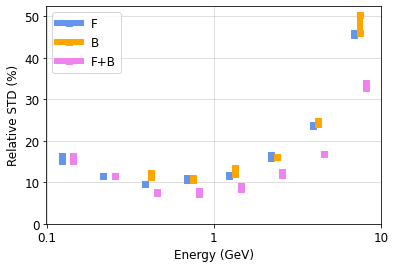 </figure>
Note that there is no Back data below 300 MeV.


In [15]:
#| code-fold: true    
@ipynb_doc
def plot_sigmas(self, **kwargs):    
    """### Resolution for Energy and event type

    The top of each bar is the measured std, and the bottom the reduction 
    possible in the absence of systematics.
    {fig}
    Note that there is no Back data below 300 MeV.
    """
    fit_info = check_fits(self)
    fig, ax = plt.subplots(figsize=(6,4))
    kw = dict(yscale='linear', ylim=(0,None), 
              xlabel='Energy (GeV)', ylabel='Relative STD (%)',
              xticks=[-0.5,3.5,7.5], xticklabels='0.1 1 10'.split())
    kw.update(kwargs)

    for ii, name, color in zip(range(3), 'F B F+B'.split(),
                              'cornflowerblue orange violet'.split()):
        y = fit_info.loc[[ii],:]
        k = np.array([t[1] for t in y.index])
        for j, sig, psig in zip(k, 100*y.sigma.values, y.pull_std.values):
            x = j + 0.14*(ii-1)
            ax.plot( [x,x], [sig/psig, sig],'s-', lw=6, color=color, label=name if j==7 else '' );
    ax.set(**kw)
    ax.grid(alpha=0.5); 
    ax.legend();   
    return locals()

plot_sigmas(self)

## Energy moment
 Return a measure of the exposure energy distribution.  
        
<figure style="margin-left: 25px" title="Figure 1">   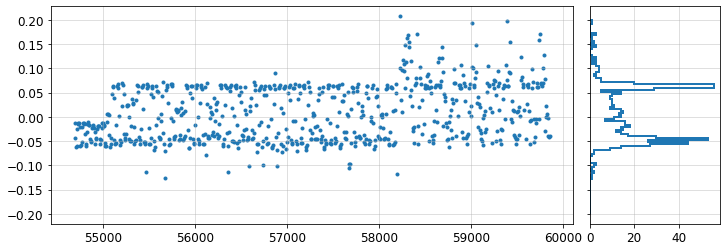 </figure>


In [16]:
#| code-fold: true
@ipynb_doc
def plot_energy_moment(self):
    """## Energy moment
    {text}
    {fig}
    """
    text = self.energy_moment.__doc__
    x = self.energy_moment()
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,4), sharey=True,
                                  gridspec_kw=dict(width_ratios=[4,1]), 
                                  #width_ratios=[4,1],
                                 ) 
    plt.subplots_adjust(wspace=0.05)
    ax1.scatter(self.cells.time.values, x, marker='.')
    ax1.grid(alpha=0.5)
    ax2.hist(x, np.linspace(-0.2,0.2,101), histtype='step', lw=2,
            orientation='horizontal');
    ax2.grid(alpha=0.5)
    return locals()

plot_energy_moment(self)

## Weighted exposure

Compare the "Kerr-mode", power-law spectral shape, with that for the source.

<figure style="margin-left: 25px" title="Figure 1">   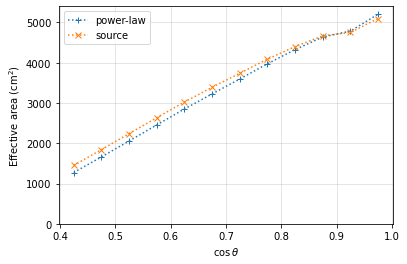 </figure>

The difference is rather small.


In [17]:
#| code-fold: true
@ipynb_doc
def plot_weighted_aeff(self, **kwargs):
    """
    ## Weighted exposure
    
    Compare the "Kerr-mode", power-law spectral shape, with that for the source.
    
    {fig}
    
    The difference is rather small.
    """

    from wtlike.exposure import weighted_aeff
    A = weighted_aeff(Config(use_kerr=True), self.source)
    Ank = weighted_aeff(Config(use_kerr=False), self.source)
    ctbins = LivetimeHistory.ctbins
    ctvals = 0.5*(ctbins[1:] + ctbins[:-1])
    Akerr = A(ctvals)
    Ankerr = Ank(ctvals)

    plt.rc('figure', figsize=(6,4))
    plt.rc('font', size=10)      

    fig, ax = plt.subplots()
    ax.plot(ctvals, Akerr, '+:', label='power-law');
    ax.plot(ctvals, Ankerr, 'x:', label='source')
    ax.set(ylabel=r'$\mathrm{Effective\ area\ (cm^2)}$', ylim=(0,None), xlabel=r'$\cos\theta$')
    ax.grid(alpha=0.4)
    ax.legend();
    return locals()
plot_weighted_aeff(self)

### Light curve and pull distribution--Front only


The left plot below shows relative flux, using all energies, for Geminga in 7-day bins,
showing the relative flux. 
<figure style="margin-left: 25px" title="Figure 1">   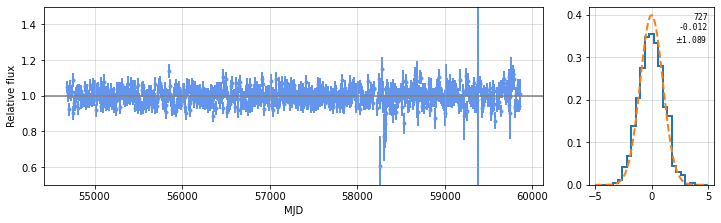 </figure>
The right plot is the distribution of the "pulls", compared with the expected Gaussian.


### Light curve and pull distribution--Back only


The left plot below shows relative flux, using all energies, for Geminga in 7-day bins,
showing the relative flux. 
<figure style="margin-left: 25px" title="Figure 1">   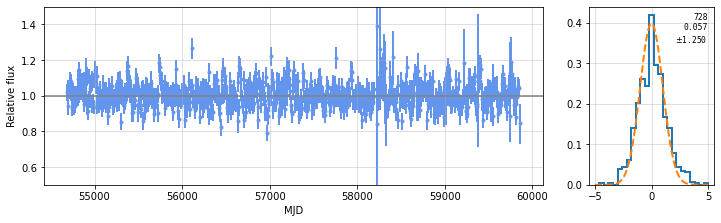 </figure>
The right plot is the distribution of the "pulls", compared with the expected Gaussian.


### Light curve and pull distribution--Front and Back


The left plot below shows relative flux, using all energies, for Geminga in 7-day bins,
showing the relative flux. 
<figure style="margin-left: 25px" title="Figure 1">   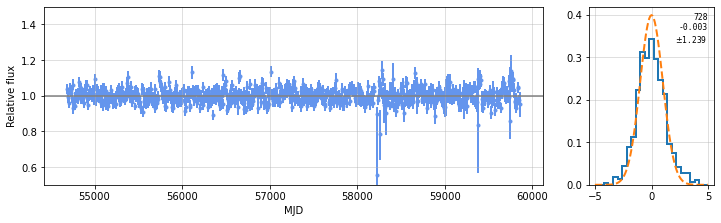 </figure>
The right plot is the distribution of the "pulls", compared with the expected Gaussian.


In [18]:
#| code-fold: true  
@ipynb_doc
def count_light_curve(self, ftmask=3, **kwargs):
    """### Light curve and pull distribution--{data}
    
   
    The left plot below shows relative flux, using all energies, for {self.source_name} in {self.interval}-day bins,
    showing the relative flux. 
    {fig}
    The right plot is the distribution of the "pulls", compared with the expected Gaussian.
    """
    from matplotlib.gridspec import GridSpec
    data = ['','Front only','Back only','Front and Back'][ftmask]
    fig = plt.figure(figsize=(12,3))
    gs = GridSpec(1, 2,  width_ratios=[4,1], wspace=0.15, top=0.95)
    (ax1,ax2) =  [fig.add_subplot(g) for g in gs]
    kw = dict(ylim=(0.5,1.5))
    kw.update(kwargs)
    ax1.set(**kw)
    ax1.axhline(1, color='grey')

    cf = self.count_flux(ftmask)    
    pulls = cf.fit.apply(lambda p: p.sigma_dev(1))
    flux_plot(cf,    ax=ax1,**kw);
    pull_plot(pulls, ax=ax2)

    return locals()



count_light_curve(self, 1)
count_light_curve(self, 2)
count_light_curve(self, 3)

### Exposure

This is the total exposure, derived from the spacecraft pointing information and the
effective area.
<figure style="margin-left: 25px" title="Figure 1">   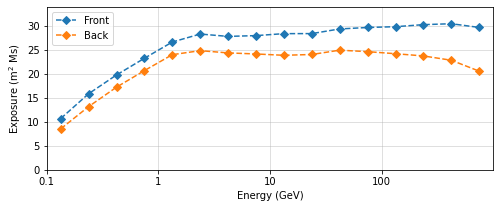 </figure>


In [19]:
#| include: false
@ipynb_doc
def plot_exposure(self, **kwargs):
    """### Exposure
    
    This is the total exposure, derived from the spacecraft pointing information and the
    effective area.
    {fig}
    """
    L = np.array([ cell['livetime'] for cell in self]).T
    F_cells = np.dot(self.Aeff, L)
    F_full = F_cells.sum(axis=2) / 1e10
    fig, ax = plt.subplots(figsize=(8,3))
    xticks=range(0,16,4)
    kw = dict(ylabel='Exposure ($\mathrm{m^2\ Ms}$)',  xlabel='Energy (GeV)',
               ylim=(0,34),xlim=(0,16),
             xticks=xticks, xticklabels='0.1 1 10 100'.split())
    kw.update(kwargs)
    ax.set(**kw)
    [ax.plot( np.arange(0.5,16,1), F, 'D--', label=label) for (F,label) in zip(F_full, 'Front Back'.split())]
    ax.grid(alpha=0.5); ax.legend()
    return locals()
plot_exposure(self)

### Cell weight plots

For each cell, the sum of the weights is an estimator for the rate. 
The exposure, which depends on the livetime and the effective area, 
provides a prediction of what it should be.
Figure 1 shows that the livetime alone is not sufficient to account
for the variation in the weight sum.
<figure style="margin-left: 25px" title="Figure 1">   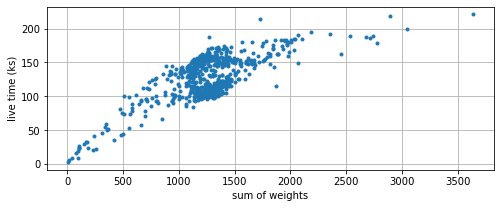  <figcaption><b>Figure 1</b>.  The total livetime per cell vs the sum of weights
        </figcaption></figure>

In Figure 2, we compare $\sum w$ with $S$ as calculated according to 
Eq. (3) above.
<figure style="margin-left: 25px" title="Figure 2">   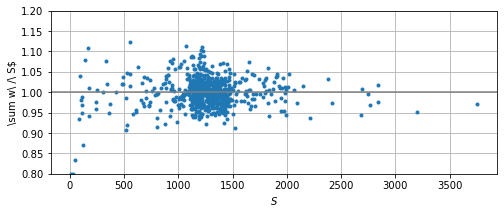  <figcaption><b>Figure 2</b>. Comparison of the ratio of the sum of weights per cell to the expected value, assuming a constant source.
        </figcaption></figure>


In [20]:
#| include: false
@ipynb_doc
def plot_cell_weights(self):
    r""" ### Cell weight plots
    
    For each cell, the sum of the weights is an estimator for the rate. 
    The exposure, which depends on the livetime and the effective area, 
    provides a prediction of what it should be.
    Figure 1 shows that the livetime alone is not sufficient to account
    for the variation in the weight sum.
    {fig1}
    
    In Figure 2, we compare $\sum w$ with $S$ as calculated according to 
    Eq. (3) above.
    {fig2}
    """
    fig1 = figure(self.plot_lt_vs_w);
    fig2 = figure(self.plot_wsum_vs_ssum);
    return locals()

plot_cell_weights(self)

In [21]:
#| code-fold: true    
@ipynb_doc    
def plot_ratio_vs_eindex(self, strategy, rlim=(0.8,1.2), **kwargs):
    """   
    ### {comment}
    {fig}
    """    
    # # S, B = self._get_S_and_B()    
    # ssum = S.sum(axis=1)
    Scell = strategy(self)
    comment = strategy.__doc__

    wsum = np.array([sum(c['w']) for c in self])
    ratio = (Scell/wsum).clip(*rlim)
    
    # Energy index weighted by exposure
    F = self._get_Fbar()[:,:8].sum(axis=2)    
    iE = np.arange(8)
    EF = (iE * F).sum(axis=1) / F.sum(axis=1)
    
    x,y = EF-3.5, ratio
    class LSQ():
        def __init__(self, x, y):
            self.a, self.b = np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y, rcond=None)[0]
        def __call__(self, x):
            return self.a*x + self.b
        def __str__(self):
            return rf'$y={self.a:.2f}x + {self.b:.2f}$'

    fitfun = LSQ(x,y) 
    
    fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(12,4), 
                                sharey=True, gridspec_kw=dict(width_ratios=[3,1]))
    plt.subplots_adjust(wspace=0.05)
    ax.plot(x,y, '.', color='cornflowerblue', label='cell data')
    ax.plot(x, fitfun(x), '--', color='orange', label=f'least-squares fit:\n{fitfun}')

    kw = dict(xlabel='Weighted Energy index', ylabel='ratio', ylim=rlim)
    kw.update(kwargs); ax.set(**kw)
    ax.grid(alpha=0.5)
    ax.legend()
    ax.axhline(1, color='grey')    
    ax2.hist(y, np.linspace(*rlim), histtype='step', lw=2, 
             orientation='horizontal', label=f'${y.mean():.3f}\pm{y.std():.3f}$')
    ax2.legend(); ax2.grid(alpha=0.5)
    ax2.axhline(1, color='grey')
    return locals()


In [22]:
#| include: false
from wtlike.exposure import  WeightedAeff
# Strategy functions
def get_S_cell(self):
    """summed Sk"""
    S, B = self._get_S_and_B()    
    return S.sum(axis=1)
# plot_ratio_vs_eindex(self, get_S_cell);
A1 = WeightedAeff(spectrum=lambda E: E**-2.1)
A2 = WeightedAeff(spectrum=self.source.spectral_model)
Gamma=-1.95
A3 = WeightedAeff(spectrum=lambda E: E**Gamma, nebins=8, imin=(0,4))
class Sbar():
    """weighted Aeff {}"""

    def __init__(self, Awt, name=''):
        self.A = Awt
        self.__doc__ = self.__doc__.format(name)
        
    def __call__(self, ef):
        L = np.array([ cell['livetime'] for cell in ef]).T
        ctbins = LivetimeHistory.ctbins
        ctvals = 0.5*(ctbins[1:] + ctbins[:-1])
        A_bar= self.A(ctvals)
        exp_bar = np.dot(A_bar, L) 
        wsum = (np.array([sum(c['w']) for c in ef])).sum()
        S_bar = (exp_bar / np.sum(exp_bar)) * wsum
        return S_bar
  

## Study exposure weighting

### summed Sk
<figure style="margin-left: 25px" title="Figure 1">   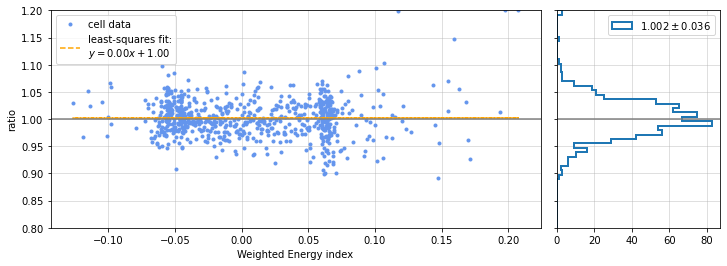 </figure>


### weighted Aeff Power-law 2.1
<figure style="margin-left: 25px" title="Figure 1">   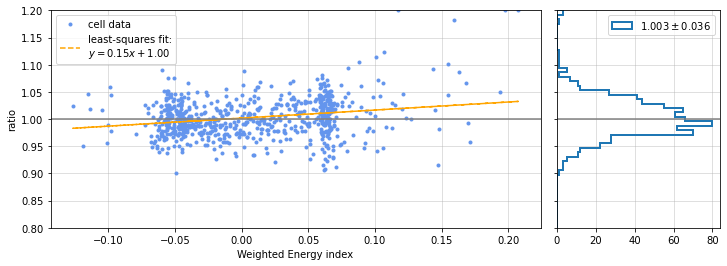 </figure>


### weighted Aeff Source spectral model
<figure style="margin-left: 25px" title="Figure 1">   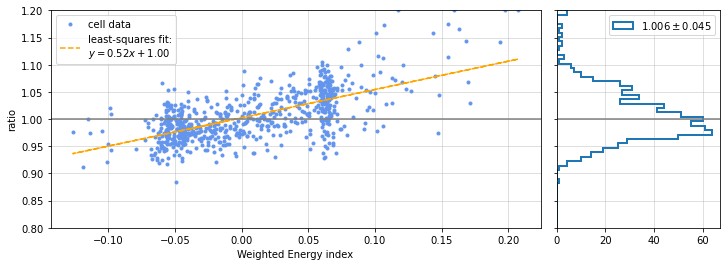 </figure>


### weighted Aeff Power-law$-1.95$
<figure style="margin-left: 25px" title="Figure 1">   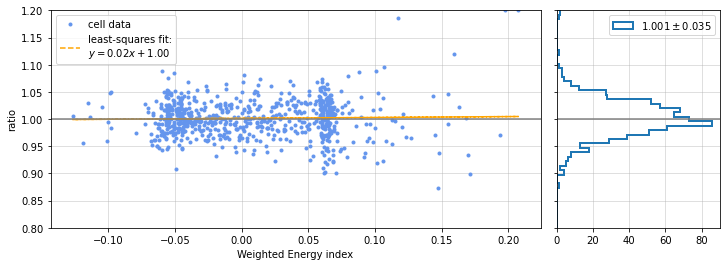 </figure>


In [23]:
#| code-fold: true
display_markdown(
"""
## Study exposure weighting
""")
plot_ratio_vs_eindex(self, get_S_cell);  
plot_ratio_vs_eindex(self, Sbar(A1,'Power-law 2.1'))
plot_ratio_vs_eindex(self, Sbar(A2, 'Source spectral model'))
plot_ratio_vs_eindex(self, Sbar(A3, f'Power-law${Gamma}$'))

In [24]:
#| include: false
@ipynb_doc
def done():
    """
    # Finished: {date} 
    """
    from nbdev import nbdev_export
    nbdev_export()
    return locals()
done()

# Finished: 2023-02-06 14:14 
